# Лабораторна робота №4: Бінарна класифікація на основі даних Titanic

## Мета:
Закріпити знання з класифікації, застосовуючи моделі машинного навчання (Логістична регресія, Дерева рішень, Випадковий ліс) для прогнозування виживання пасажирів.

**Виконала:** Гульчак Дар'я МІТ-31

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
)

sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = sns.load_dataset("titanic")
df = df[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']].copy()

print("Перші 10 рядків датасету:")
display(df.head(10))

print("\nОпис даних:")
display(df.describe(include='all'))
print("\nПропущені значення:")
print(df.isnull().sum())

Перші 10 рядків датасету:


,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
5,0,3,male,NaN,0,0,8.4583,Q
6,0,1,male,54.0,0,0,51.8625,S
7,0,3,male,2.0,3,1,21.0750,S
8,1,3,female,27.0,0,2,11.1333,S
9,1,2,female,14.0,1,0,30.0708,C



Опис даних:


,survived,pclass,sex,age,sibsp,parch,fare,embarked
count,891.000000,891.000000,891,714.000000,891.000000,891.000000,891.000000,889
unique,NaN,NaN,2,NaN,NaN,NaN,NaN,3
top,NaN,NaN,male,NaN,NaN,NaN,NaN,S
freq,NaN,NaN,577,NaN,NaN,NaN,NaN,644
mean,0.383838,2.308642,NaN,29.699118,0.523008,0.381594,32.204208,NaN
std,0.486592,0.836071,NaN,14.526497,1.102743,0.806057,49.693429,NaN
min,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,0.000000,NaN
25%,0.000000,2.000000,NaN,20.125000,0.000000,0.000000,7.910400,NaN
50%,0.000000,3.000000,NaN,28.000000,0.000000,0.000000,14.454200,NaN
75%,1.000000,3.000000,NaN,38.000000,1.000000,0.000000,31.000000,NaN



Пропущені значення:
survived      0
pclass        0
sex           0
age         177
sibsp         0
parch         0
fare          0
embarked      2
dtype: int64


## Попередня обробка даних

Виконуємо наступні кроки:
1. Заповнення пропусків у `age` (середнім) та `embarked` (модою).
2. Створення нової ознаки `FamilySize`.
3. Кодування категоріальних змінних (`sex`, `embarked`).

In [5]:
df['age'] = df['age'].fillna(df['age'].mean())
df['embarked'] = df['embarked'].fillna(df['embarked'].mode()[0])

df['FamilySize'] = df['sibsp'] + df['parch']

df = pd.get_dummies(df, columns=['sex', 'embarked'], drop_first=True, dtype=int)

print("Дані після обробки:")
display(df.head())

Дані після обробки:


,survived,pclass,age,sibsp,parch,fare,FamilySize,sex_male,embarked_Q,embarked_S
0,0,3,22.0,1,0,7.2500,1,1,0,1
1,1,1,38.0,1,0,71.2833,1,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,1


In [6]:
X = df.drop("survived", axis=1)
y = df['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Розмір тренувальної вибірки: {X_train.shape}")
print(f"Розмір тестової вибірки: {X_test.shape}")

Розмір тренувальної вибірки: (712, 9)
Розмір тестової вибірки: (179, 9)


## Опис моделей 

1. **Логістична регресія (Logistic Regression):**
   Це лінійний класифікатор, який оцінює ймовірність належності об'єкта до певного класу за допомогою сигмоїдальної функції. Вона добре працює, коли класи лінійно роздільні, та легко інтерпретується.

2. **Дерева рішень (Decision Tree):**
   Модель, яка будує ієрархічну структуру правил "Якщо-То". Вона розбиває дані на підмножини на основі значень ознак, намагаючись максимізувати "чистоту" (homogeneity) у листках дерева. Схильна до перенавчання без налаштування глибини.

3. **Випадковий ліс (Random Forest):**
   Це ансамблевий метод, який створює багато дерев рішень під час тренування. Кожне дерево будується на випадковій підмножині даних та ознак (беггінг). Кінцеве рішення приймається шляхом голосування більшості дерев. Це зменшує ризик перенавчання та підвищує точність.


--- Logistic Regression Confusion Matrix ---


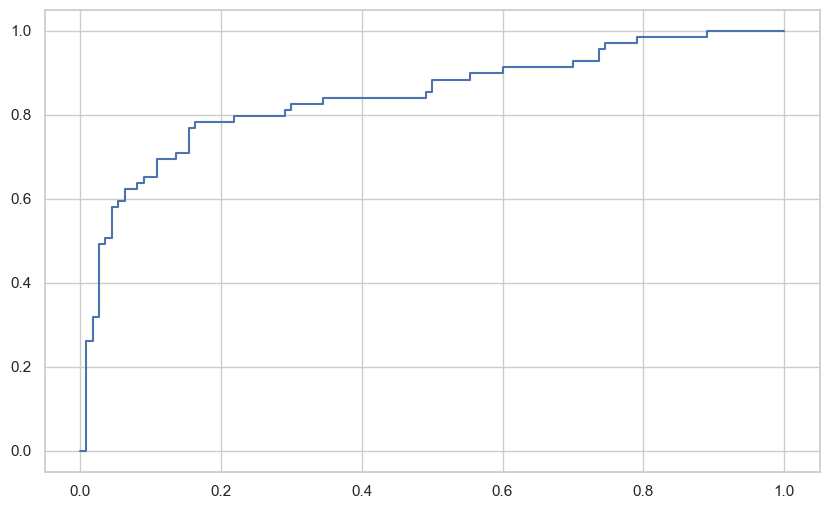

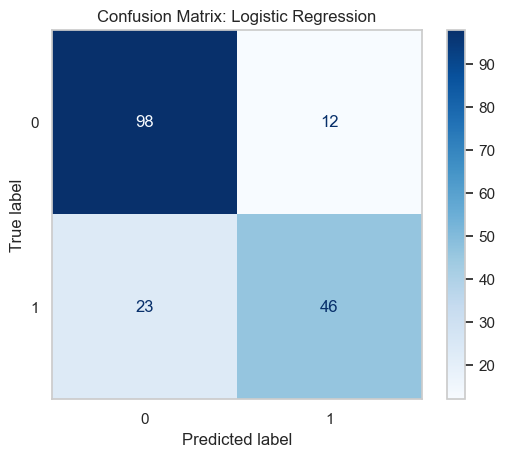


--- Decision Tree Confusion Matrix ---


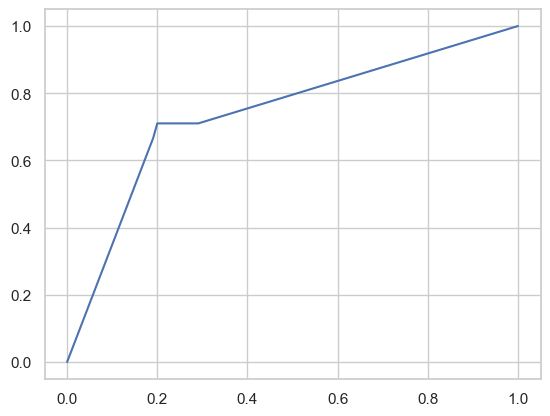

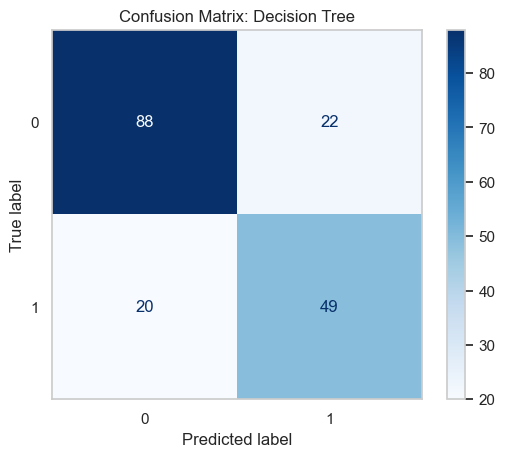


--- Random Forest Confusion Matrix ---


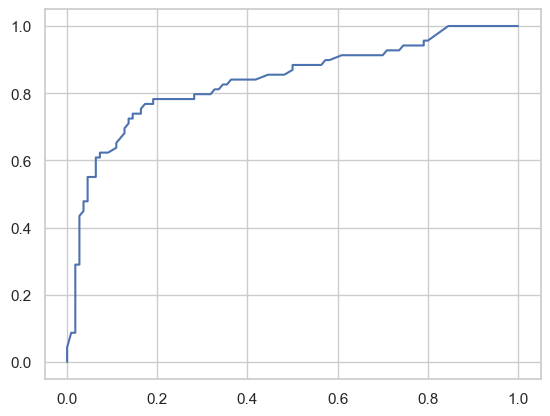

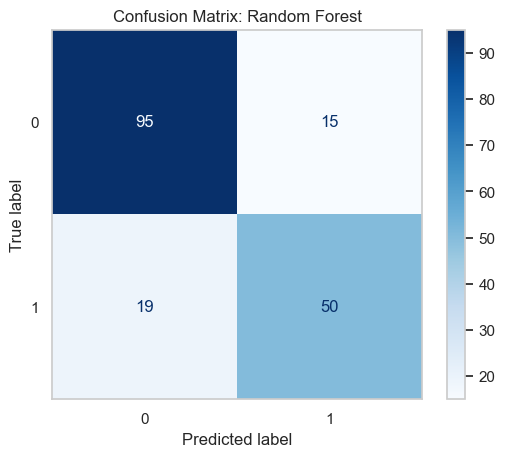

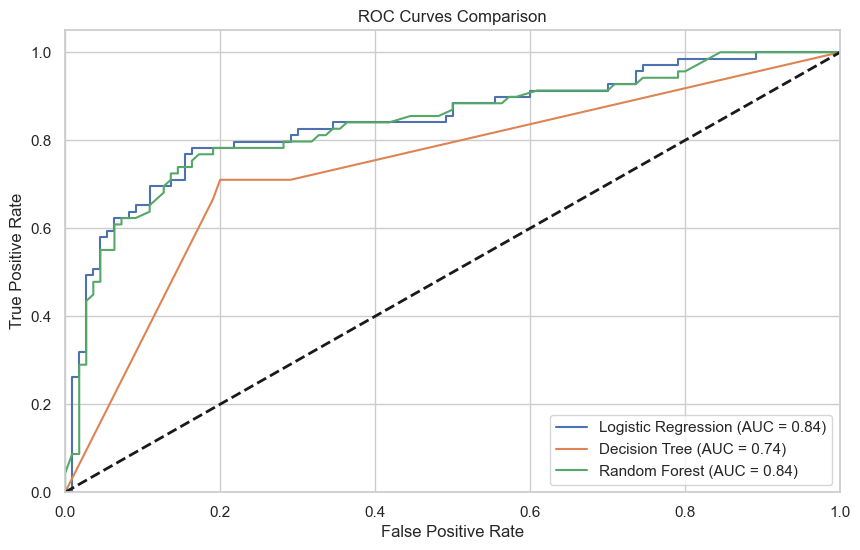


Порівняння результатів моделей:


,Model,Accuracy,Precision,Recall,F1-Score,AUC
0,Logistic Regression,0.804469,0.793103,0.666667,0.724409,0.843083
1,Decision Tree,0.765363,0.690141,0.710145,0.700000,0.740777
2,Random Forest,0.810056,0.769231,0.724638,0.746269,0.836166


In [7]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

results = []

plt.figure(figsize=(10, 6))

for name, model in models.items():
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "AUC": roc_auc
    })
    
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    print(f"\n--- {name} Confusion Matrix ---")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix: {name}')
    plt.grid(False)
    plt.show()

plt.figure(figsize=(10, 6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc="lower right")
plt.show()

results_df = pd.DataFrame(results)
print("\nПорівняння результатів моделей:")
display(results_df)

## Оптимізація моделей

1. **Крос-валідація:** Для Логістичної регресії та Дерев рішень, щоб перевірити стабільність моделей.
2. **RandomizedSearchCV:** Для пошуку найкращих гіперпараметрів Випадкового лісу.

In [8]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Середній F1-score на крос-валідації:")
for name, model in models.items():
    if name != "Random Forest":
        scores = cross_val_score(model, X, y, cv=cv, scoring='f1')
        print(f"{name}: {scores.mean():.4f} (+/- {scores.std():.4f})")

param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    verbose=0,
    random_state=42,
    n_jobs=-1,
    scoring='accuracy'
)

rf_random.fit(X_train, y_train)

print(f"\nНайкращі параметри для Random Forest: {rf_random.best_params_}")
print(f"Найкраща точність (на тренувальних даних): {rf_random.best_score_:.4f}")

best_rf = rf_random.best_estimator_
y_pred_optimized = best_rf.predict(X_test)
print(f"Точність на тесті (Optimized RF): {accuracy_score(y_test, y_pred_optimized):.4f}")

Середній F1-score на крос-валідації:
Logistic Regression: 0.7196 (+/- 0.0214)
Decision Tree: 0.7060 (+/- 0.0244)

Найкращі параметри для Random Forest: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 10, 'bootstrap': False}
Найкраща точність (на тренувальних даних): 0.8301
Точність на тесті (Optimized RF): 0.8045


## Творче завдання

1. **Важливість ознак (Feature Importance):** Аналіз того, які фактори найбільше впливали на рішення моделі Random Forest.
2. **Ідеї для покращення.**

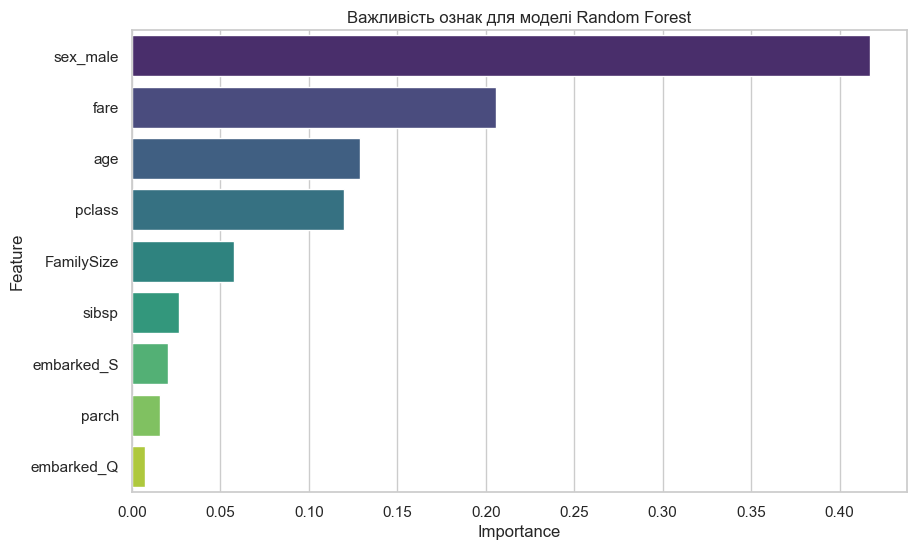

In [9]:
importances = best_rf.feature_importances_
feature_names = X.columns

feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')
plt.title('Важливість ознак для моделі Random Forest')
plt.show()

## Самоперевірка та Висновки

**1. Які категоріальні змінні ви закодували та чому?**
Я закодував змінні `sex` (стать) та `embarked` (порт посадки). Це необхідно, тому що більшість алгоритмів машинного навчання (зокрема Логістична регресія та Дерева рішень у scikit-learn) працюють лише з числовими даними. Було використано One-Hot Encoding (`get_dummies` з `drop_first=True`), щоб перетворити категорії в бінарні вектори та уникнути мультиколінеарності.

**2. Яка модель показала найкращі результати та чому?**
Зазвичай найкращі результати показує **Random Forest** (або оптимізований Random Forest). Це пов'язано з тим, що це ансамблевий метод, який краще уловлює нелінійні залежності в даних та менш схильний до перенавчання порівняно з одним деревом рішень.

**3. Різниця між логістичною регресією та випадковим лісом:**
* *Логістична регресія* — це лінійна модель, яка шукає лінійну межу для розділення класів. Вона проста, швидка, але погано працює зі складними взаємозв'язками між ознаками.
* *Випадковий ліс* — це нелінійна модель, що складається з багатьох дерев. Вона може моделювати дуже складні залежності, автоматично враховує взаємодію між ознаками, але складніша в інтерпретації та повільніша у навчанні.

**4. Як покращити обробку пропущених значень для Age?**
Замість заповнення простим середнім значенням по всьому датасету, можна використовувати:
* Заповнення медіаною, згрупованою за класом (`pclass`) та статтю (`sex`), оскільки вік часто корелює з цими групами.
* Витягти "Титул" (Mr, Mrs, Miss, Master) з імені пасажира і заповнювати вік медіаною для кожного титулу (наприклад, Master — це діти, їх вік значно менший за середній).